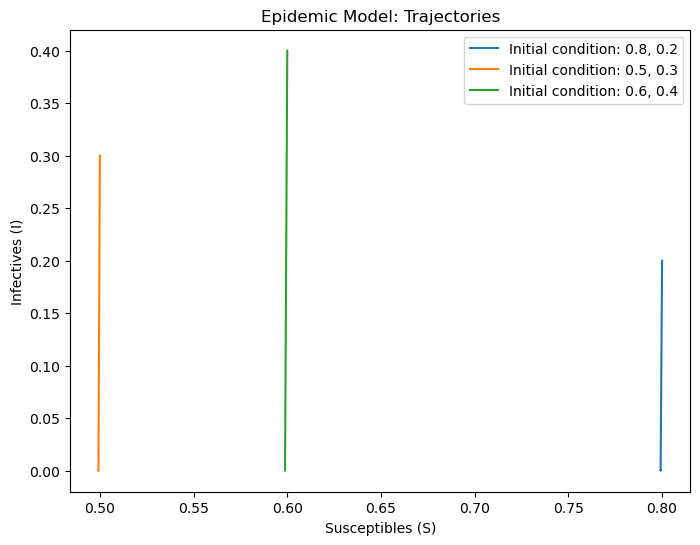

In [10]:
import sympy as sp
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

sp.init_printing()

t = sp.Symbol("t")
S = sp.Function("S")
I = sp.Function("I")
R = sp.Function("R")
B = sp.Symbol("B")
G = sp.Symbol("G")



ode1l = S(t).diff(t)
ode1r = -B * S(t) * I(t)
ode1 = sp.Eq(ode1l, ode1r)

ode2l = I(t).diff(t)
ode2r = (B * S(t) * I(t)) - G * I(t)
ode2 = sp.Eq(ode2l, ode2r)

ode3l = G.diff(t)
ode3r = G*I(t)
ode3 = sp.Eq(ode3l,ode3r)


B_val = 2.18e-3
G_val = 0.44

ode1 = ode1.subs({B: B_val})
ode2 = ode2.subs({B: B_val, G: G_val})
ode3 = ode3.subs({G : G_val})

time_span = (0, 1000)
time_eval = np.linspace(time_span[0], time_span[1], 1000)

# Convert symbolic expressions to callable functions
ode1_func = sp.lambdify((S(t), I(t)), ode1.rhs, 'numpy')
ode2_func = sp.lambdify((S(t), I(t)), ode2.rhs, 'numpy')

# Define initial conditions
initial_conditions = [
    (0.8, 0.2),
    (0.5, 0.3),
    (0.6, 0.4),
]

def fun_ilp(t, y):
    return  [ode1_func(y[0], y[1]), ode2_func(y[0], y[1])]

# Plot the solution trajectories
plt.figure(figsize=(8, 6))
for init_cond in initial_conditions:
    solution = solve_ivp(
        fun=fun_ilp,
        t_span=time_span,
        y0=init_cond,
        method="RK45",
        t_eval=time_eval,
    )
    plt.plot(solution.y[0], solution.y[1], label=f"Initial condition: {init_cond[0]}, {init_cond[1]}")

plt.title("Epidemic Model: Trajectories")
plt.xlabel("Susceptibles (S)")
plt.ylabel("Infectives (I)")
plt.legend()

plt.show()

In [6]:
max_x, max_y = 0, 0  
max_x = max(max_x, np.max(solution.y[0]))
max_y = max(max_y, np.max(solution.y[1]))

print("Maximum value over x-axis:", max_x)
print("Maximum value over y-axis:", max_y)

Maximum value over x-axis: 0.6
Maximum value over y-axis: 0.4


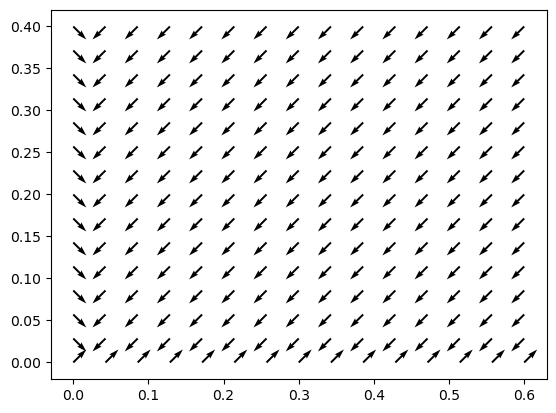

In [13]:
x = np.linspace(0, max_x, 15)
y = np.linspace(0, max_y, 15)
X_mesh, Y_mesh = np.meshgrid(x, y)
slopes_ode1 = ode1_func(X_mesh, Y_mesh)
slopes_ode2 = ode2_func(X_mesh, Y_mesh)
slopes_ode1[slopes_ode1==0]=1
slopes_ode2[slopes_ode2==0]=1
slopes_ode1n=slopes_ode1/abs(slopes_ode1) #normalization of slope points
slopes_ode2n=slopes_ode2/abs(slopes_ode2)

plt.quiver(X_mesh, Y_mesh, slopes_ode1n, slopes_ode2n)

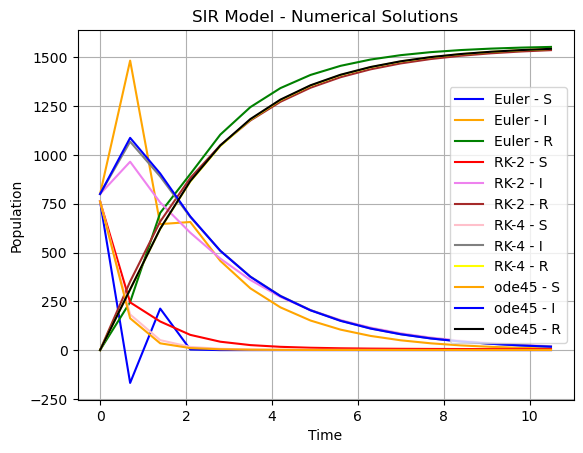

In [9]:
def sir_model(t, y, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]
def euler_method(func, y0, t_span, h, beta, gamma):
    t_values = np.arange(t_span[0], t_span[1] + h, h)
    y_values = [y0]
    for t in t_values[:-1]:
        y0 = y0 + h * np.array(func(t, y0, beta, gamma))
        y_values.append(y0)
    return np.array(t_values), np.array(y_values)
def rk2_method(func, y0, t_span, h, beta, gamma):
    t_values = np.arange(t_span[0], t_span[1] + h, h)
    y_values = [y0]
    for t in t_values[:-1]:
        k1 = h * np.array(func(t, y0, beta, gamma))
        k2 = h * np.array(func(t + h/2, y0 + k1/2, beta, gamma))
        y0 = y0 + k2
        y_values.append(y0)
    return np.array(t_values), np.array(y_values)
def rk4_method(func, y0, t_span, h, beta, gamma):
    t_values = np.arange(t_span[0], t_span[1] + h, h)
    y_values = [y0]
    for t in t_values[:-1]:
        k1 = h * np.array(func(t, y0, beta, gamma))
        k2 = h * np.array(func(t + h/2, y0 + k1/2, beta, gamma))
        k3 = h * np.array(func(t + h/2, y0 + k2/2, beta, gamma))
        k4 = h * np.array(func(t + h, y0 + k3, beta, gamma))
        y0 = y0 + (k1 + 2*k2 + 2*k3 + k4)/6
        y_values.append(y0)
    return np.array(t_values), np.array(y_values)
def ode45_method(func, t_span, y0, beta, gamma):
    solution = solve_ivp(func, t_span, y0, method='RK45', args=(beta, gamma), t_eval=np.arange(t_span[0], t_span[1] + t_step, t_step))
    return solution.t, solution.y.T

beta_val = 2.18e-3 
gamma_val = 0.44    
initial_conditions = [762, 800, 0]  
t_span = [0, 10.5]
t_step = 0.7

t_euler, solution_euler = euler_method(sir_model, initial_conditions, t_span, t_step, beta_val, gamma_val)
t_rk2, solution_rk2 = rk2_method(sir_model, initial_conditions, t_span, t_step, beta_val, gamma_val)
t_rk4, solution_rk4 = rk4_method(sir_model, initial_conditions, t_span, t_step, beta_val, gamma_val)
t_ode45, solution_ode45 = ode45_method(sir_model, t_span, initial_conditions, beta_val, gamma_val)

plt.plot(t_euler, solution_euler[:, 0],color="blue" ,label='Euler - S')
plt.plot(t_euler, solution_euler[:, 1],color="orange" , label='Euler - I')
plt.plot(t_euler, solution_euler[:, 2],color="green" , label='Euler - R')
plt.plot(t_rk2, solution_rk2[:, 0],color="red" , label='RK-2 - S')
plt.plot(t_rk2, solution_rk2[:, 1],color="violet" , label='RK-2 - I')
plt.plot(t_rk2, solution_rk2[:, 2],color="brown" , label='RK-2 - R')
plt.plot(t_rk4, solution_rk4[:, 0],color="pink" , label='RK-4 - S')
plt.plot(t_rk4, solution_rk4[:, 1],color="grey" , label='RK-4 - I')
plt.plot(t_rk4, solution_rk4[:, 2],color="yellow" , label='RK-4 - R')
plt.plot(t_ode45, solution_ode45[:, 0],color="orange" , label='ode45 - S')
plt.plot(t_ode45, solution_ode45[:, 1],color="blue" , label='ode45 - I')
plt.plot(t_ode45, solution_ode45[:, 2],color="black", label='ode45 - R')
plt.title('SIR Model - Numerical Solutions')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.show()